# Global Peace Index. Relationship with other indicators.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Point
import geodatasets
import matplotlib.colors as colors
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression



## Introduction

During recent years there is a feeling that the world has become less peaceful, with higher complexity, rise in civil unrest, and more conflicts than 10-15 years ago. Whether this is just a gut feeling or is actually backed with data, we will find out by exploring the GPI (Global Peace Index). We will also try to connect it with other indicators and examine their associations.

## Global Peace Index (GPI)

The Global Peace Index is a report, created by the Institute for Economics & Peace, and it measures the relative peacefulness of nations. It ranks 163 independent states and territories, which collectively account for 99.7% of the world's population. It is calculated using [23 qualitative and quantitive indicators](https://www.visionofhumanity.org/chart-of-the-week-indicators-of-peace/) across three main domains: level of Societal Safety and Security, the extent of Ongoing Domestic and International Conflict, degree of Militarisation. It is important to note that  **higher GPI means less peaceful and lower GPI - more peaceful**.

Let's start by reading the file that we have until 2023 (including).

Since the delimiter in the csv file appears to be a semicolumn and the decimal - a comma, we explicitly say that when reading the file:

In [3]:
peace_index = pd.read_csv("data/peace_index.csv", delimiter = ";", decimal = ",")

In [4]:
peace_index.head()

,Country,iso3c,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,3.153,3.246,3.087,3.038,3.069,3.101,3.095,3.108,3.369,3.480,3.513,3.636,3.626,3.626,3.626,3.434
1,Angola,AGO,1.655,1.827,1.615,1.816,1.615,1.615,1.609,1.408,1.403,1.403,1.610,1.615,1.413,1.621,1.608,1.639
2,Albania,ALB,1.247,1.270,1.293,1.293,1.293,1.282,1.270,1.259,1.259,1.247,1.236,1.224,1.414,1.403,1.403,1.403
3,United Arab Emirates,ARE,1.000,1.000,1.000,1.213,1.238,1.241,1.253,1.264,1.477,1.517,1.563,1.598,1.833,1.701,1.689,1.678
4,Argentina,ARG,1.403,1.604,1.604,1.403,1.403,1.604,1.403,1.403,1.403,1.403,1.201,1.201,1.201,1.201,1.201,1.201


It seems that every year's data is in a separate columns, which we shall fix. The "iso3c" field refers to the country code, so we should rename it.

In [5]:
peace_index.rename(columns = {"iso3c": "Country_code"}, inplace = True)

There are 163 rows and 18 columns:

In [6]:
peace_index.shape

(163, 18)

In [7]:
peace_index = peace_index.melt(id_vars = ["Country","Country_code"], var_name = ["Year"], value_name = "GPI")

This is how the dataset looks like after the change:

In [8]:
peace_index.head()

,Country,Country_code,Year,GPI
0,Afghanistan,AFG,2008,3.153
1,Angola,AGO,2008,1.655
2,Albania,ALB,2008,1.247
3,United Arab Emirates,ARE,2008,1.000
4,Argentina,ARG,2008,1.403


In [9]:
peace_index.shape

(2608, 4)

It now has 2608 rows and only 4 columns.

In [10]:
peace_index.describe().T

,count,mean,std,min,25%,50%,75%,max
GPI,2596.0,1.714369,0.568415,1.0,1.403,1.604,2.006,3.828


We see that the count for GPI is 2596, while the total rows are 2608 - it seems that there are missing values. Let's see which are they.

In [11]:
peace_index[peace_index.GPI.isna()].sort_values("Country")

,Country,Country_code,Year,GPI
122,Palestine,PSE,2008,NaN
285,Palestine,PSE,2009,NaN
448,Palestine,PSE,2010,NaN
611,Palestine,PSE,2011,NaN
774,Palestine,PSE,2012,NaN
937,Palestine,PSE,2013,NaN
1100,Palestine,PSE,2014,NaN
1263,Palestine,PSE,2015,NaN
135,South Sudan,SSD,2008,NaN
298,South Sudan,SSD,2009,NaN


There are two states that have missing GPI - Palestine and South Sudan, with Palestine having more. We don't want to lose the records for these countries for those specific years, so what we can do is mean imputation - fill the NaN values with the mean GPI for the respective country. In the Palestine case, the missing values are 8 and the present ones are 8, so it would be more risky, but we will take that risk and proceed.

In [12]:
def fill_na_with_mean (dataset, country, feature):
    """
    This function replaces NaN values for GPI in the Country column,
    filtering the specific country based on what we input,
    with the average for that country.
    """
   # mean_feature_country = dataset[dataset.Country == country].feature.mean()
    #dataset.loc[(dataset['Country'] == country)].feature = dataset.loc[(dataset['Country'] == country)].feature.fillna(mean_gpi_country)
    #return peace_index
    mean_gpi_country = peace_index[peace_index.Country == country].GPI.mean()
    peace_index.loc[(peace_index['Country'] == country)] = peace_index.loc[(peace_index['Country'] == country)].fillna(mean_gpi_country)

In [13]:
fill_na_with_mean(peace_index, "Palestine", "GPI"), fill_na_with_mean(peace_index, "South Sudan", "GPI")

(None, None)

Checking the results after running the above function:

In [14]:
peace_index[peace_index.Country == "South Sudan"]

,Country,Country_code,Year,GPI
135,South Sudan,SSD,2008,2.999417
298,South Sudan,SSD,2009,2.999417
461,South Sudan,SSD,2010,2.999417
624,South Sudan,SSD,2011,2.999417
787,South Sudan,SSD,2012,2.208000
950,South Sudan,SSD,2013,2.761000
1113,South Sudan,SSD,2014,3.175000
1276,South Sudan,SSD,2015,3.095000
1439,South Sudan,SSD,2016,3.203000
1602,South Sudan,SSD,2017,3.190000


In [15]:
peace_index[peace_index.Country == "Palestine"]

,Country,Country_code,Year,GPI
122,Palestine,PSE,2008,2.581375
285,Palestine,PSE,2009,2.581375
448,Palestine,PSE,2010,2.581375
611,Palestine,PSE,2011,2.581375
774,Palestine,PSE,2012,2.581375
937,Palestine,PSE,2013,2.581375
1100,Palestine,PSE,2014,2.581375
1263,Palestine,PSE,2015,2.581375
1426,Palestine,PSE,2016,2.880000
1589,Palestine,PSE,2017,2.505000


We can now see that the function worked and there are no NaN values.

In [16]:
peace_index.dtypes

Country          object
Country_code     object
Year             object
GPI             float64
dtype: object

While observing the data above, it's noticeable that the Year's dtype is "object". It makes more sense to be in "int", so we'll change it.

In [17]:
peace_index.Year = peace_index.Year.astype(int)

In [18]:
peace_index.dtypes

Country          object
Country_code     object
Year              int32
GPI             float64
dtype: object

The dataset looks clean now and we can start exploring it. Let's first see the GPI Distribution.

### GPI Distribution

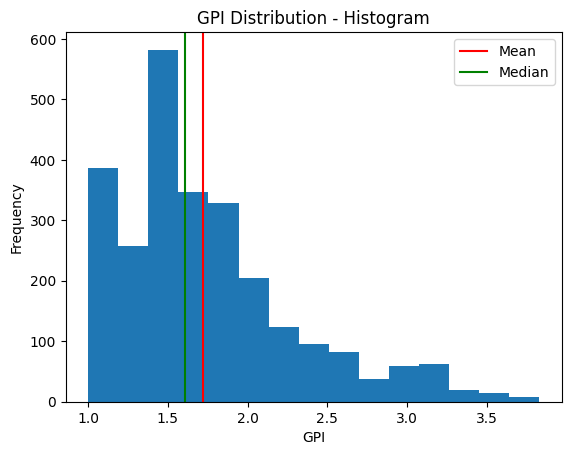

In [19]:
# Histogram review of the data:
plt.hist(peace_index.GPI, bins = 15)
plt.axvline(peace_index.GPI.mean(), color = "r", label = "Mean") 
plt.axvline(peace_index.GPI.median(), color = "g", label = "Median")
plt.xlabel("GPI")
plt.ylabel("Frequency")
plt.title("GPI Distribution - Histogram")
plt.legend()
plt.show()

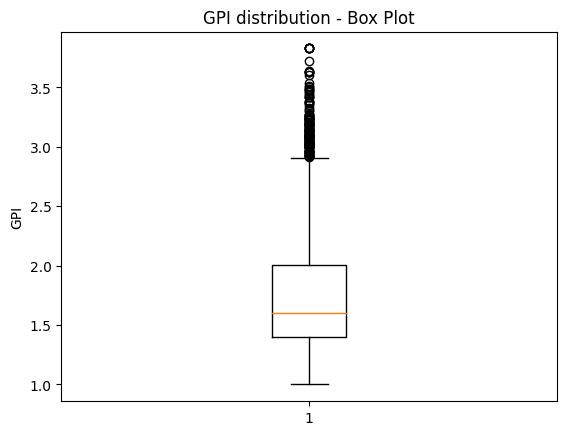

Number of outliers: 154


In [20]:
# Boxplot Review
boxplot_dict = plt.boxplot(peace_index.GPI)
outlier_data = boxplot_dict["fliers"][0].get_data()[1] # getting the fliers (outliers) 
plt.ylabel("GPI")
plt.title("GPI distribution - Box Plot")

plt.show()

print("Number of outliers:", len(outlier_data)) #number of outliers

Both of the above charts show us the distribution, but with a different visualisation. 75% of the GPIs are up to 2.0, then the frequency dilutes and above 3 are situated outliers (as per the box plot). The distribution is right-skewed with a longer tail on the right side of the distribution, the mode (peak) is around 1.4, median - 1.6 and mean - 1.7. The explanation for the right skewness is that there is a floor effect - a minimum value that the GPI can take and it starts from 1. There cannot be values below that. We should also keep in mind that we have data per year and in the above distributions one country will be listed 16 times (the GPI will be different though), which means that the number of outliers can be higher than the number of unique countries included there. On the above boxplot chart we see that the number of outlier markers is 154. Let's see how many unique countries as outliers.

To do that, we must first check what is the GPI value at the top end of the whisker:

In [21]:
upper_whisker_boundary = boxplot_dict["whiskers"][1].get_ydata()[1]

In [22]:
print(upper_whisker_boundary)

2.91


Then, we'll use this GPI to filter the unique countries who are above it:

In [23]:
peace_index[peace_index.GPI >= upper_whisker_boundary].Country.unique() # seeing which are those countries

array(['Afghanistan', 'Iraq', 'Lebanon', 'Sudan', 'Somalia',
       'South Sudan', 'Chad', 'Pakistan', 'Syria',
       'Central African Republic', 'Libya', 'Nigeria', 'Ukraine', 'Yemen',
       'Democratic Republic of the Congo', 'Turkiye', 'Iran', 'Cameroon',
       'Burkina Faso', 'Ethiopia', 'Mali', 'Niger', 'Russia'],
      dtype=object)

In [24]:
peace_index[peace_index.GPI >= upper_whisker_boundary].Country.nunique() # the number of unique countries

23

This would indicate that some of those countries have consistently high GPI throught the years. We can that below:

In [25]:
peace_index[peace_index.GPI >= upper_whisker_boundary].groupby("Country").GPI.count().sort_values(ascending = False)

Country
Afghanistan                         16
Somalia                             16
Pakistan                            15
Sudan                               14
South Sudan                         14
Iraq                                11
Syria                               11
Yemen                                8
Libya                                7
Democratic Republic of the Congo     6
Turkiye                              6
Ukraine                              6
Iran                                 4
Central African Republic             4
Nigeria                              3
Chad                                 3
Cameroon                             3
Burkina Faso                         2
Ethiopia                             2
Lebanon                              1
Niger                                1
Russia                               1
Mali                                 1
Name: GPI, dtype: int64

Let's see how the distribution of GPI would like per year in boxplots:

In [26]:
# grouping GPI per year and then putting it in a list,
# so we can use it after that in the plotting the boxplots with corresponding labels
grouped_data = peace_index.groupby("Year")["GPI"].apply(list) 

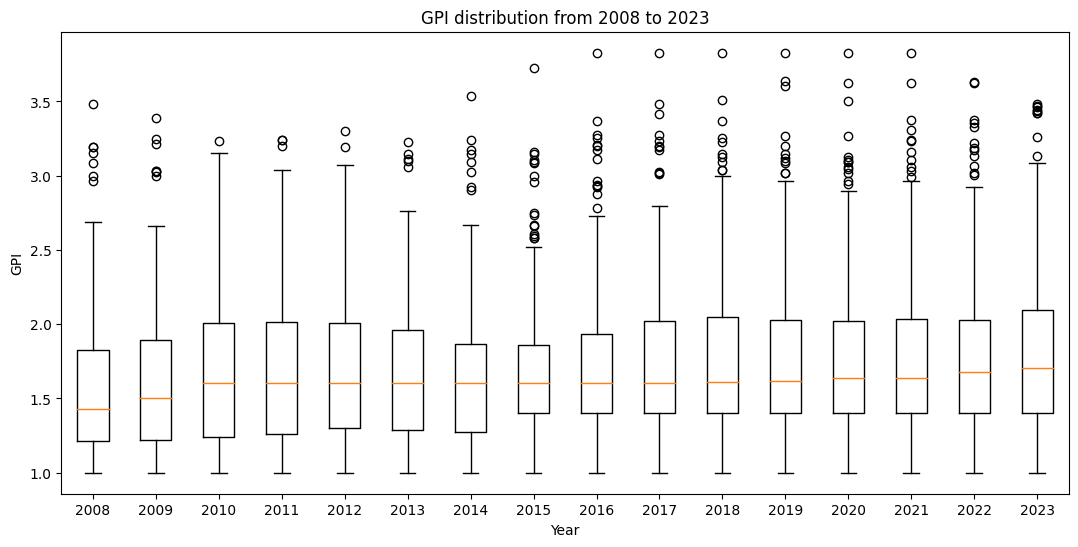

In [27]:
plt.figure(figsize = (13, 6))
plt.boxplot(grouped_data.values)
plt.xticks(range(1, len(grouped_data) + 1), grouped_data.index)
plt.ylabel("GPI")
plt.xlabel("Year")
plt.title("GPI distribution from 2008 to 2023")
plt.show()

The distributions remain relatively the same throughout the years - most of the countries have a smaller than 2 GPI (they are more peaceful), while the upper whisker remains longer (fewer countries have higher GPI) and there are always some outliers above the whisker. The median GPI stays put around 1.5 over the years.

Let's also see how the average GPI moves over the years. In order to do that, we will group the mean GPI per year.

### GPI review - 2008 to 2023

In [28]:
peace_index

,Country,Country_code,Year,GPI
0,Afghanistan,AFG,2008,3.153
1,Angola,AGO,2008,1.655
2,Albania,ALB,2008,1.247
3,United Arab Emirates,ARE,2008,1.000
4,Argentina,ARG,2008,1.403
...,...,...,...,...
2603,Vietnam,VNM,2023,1.403
2604,Yemen,YEM,2023,3.486
2605,South Africa,ZAF,2023,2.083
2606,Zambia,ZMB,2023,1.577


In [29]:
peace_index.groupby("Year").GPI.mean()

Year
2008    1.631164
2009    1.649305
2010    1.666299
2011    1.661796
2012    1.658082
2013    1.671168
2014    1.671916
2015    1.674683
2016    1.703908
2017    1.744160
2018    1.762656
2019    1.773644
2020    1.786423
2021    1.791233
2022    1.814706
2023    1.842847
Name: GPI, dtype: float64

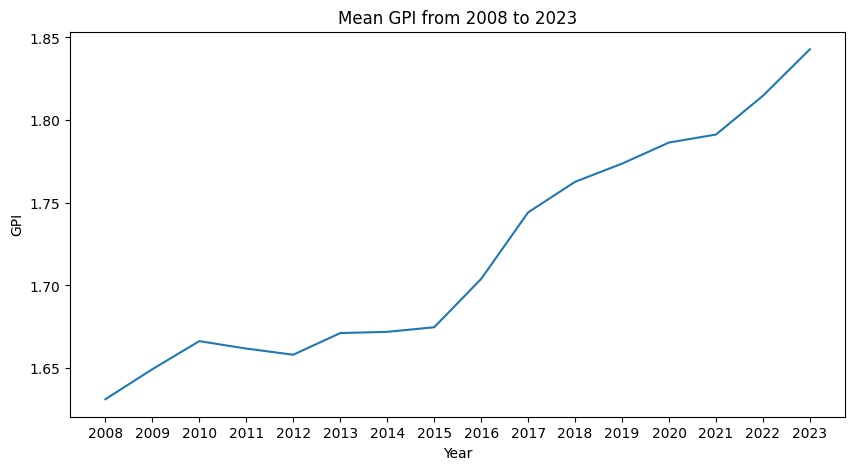

In [30]:
plt.figure(figsize= (10, 5))
plt.plot(peace_index.groupby("Year").GPI.mean())
plt.xlabel("Year")
plt.ylabel("GPI")
plt.xticks(range(2008, 2024))
plt.title("Mean GPI from 2008 to 2023")
plt.show()

By looking at the graph above, it looks like the world is deteriorating with each year, and especially after 2015 where we have a steep increase of the GPI. However, we need to note that the GPI range on the graph is small - from 1.5 to 1.85. Yes, we can say that the world is a less peaceful place now than it was in every year before 2023, but we need to be careful when expressing the extent of that deterioration. Looking only at the above graph could give us falsely elevated notion.

We can also see the GPI trendline, having placed the range of GPI to be between its min and max values, which would show the world deteriorating in a bit different perspective:

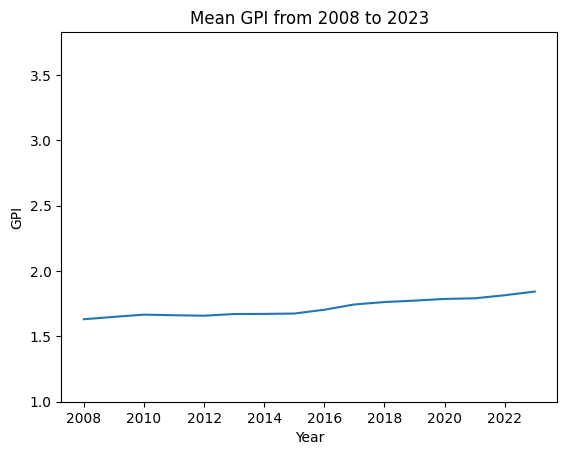

In [31]:
plt.plot(peace_index.groupby("Year").GPI.mean())
plt.xlabel("Year")
plt.ylabel("GPI")
plt.ylim(peace_index.GPI.min(), peace_index.GPI.max())
plt.title("Mean GPI from 2008 to 2023")
plt.show()

Let's investigate which countries are responsible for the spike from 2015 to 2017.

In [32]:
peace_index_pivot = peace_index.pivot(index = "Country", columns = "Year", values = "GPI") #in order to get the GPI changes, we will make a pivot

In [33]:
peace_index_pivot.head()

Year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Country,,,,,,,,,,,,,,,,
Afghanistan,3.153,3.246,3.087,3.038,3.069,3.101,3.095,3.108,3.369,3.480,3.513,3.636,3.626,3.626,3.626,3.434
Albania,1.247,1.270,1.293,1.293,1.293,1.282,1.270,1.259,1.259,1.247,1.236,1.224,1.414,1.403,1.403,1.403
Algeria,2.111,2.149,2.109,2.352,2.094,2.093,2.087,2.088,2.061,2.067,2.063,2.057,2.041,1.832,2.029,1.821
Angola,1.655,1.827,1.615,1.816,1.615,1.615,1.609,1.408,1.403,1.403,1.610,1.615,1.413,1.621,1.608,1.639
Argentina,1.403,1.604,1.604,1.403,1.403,1.604,1.403,1.403,1.403,1.403,1.201,1.201,1.201,1.201,1.201,1.201


In [34]:
change_2015_2017_pct = (peace_index_pivot[2017] - peace_index_pivot[2015]) / peace_index_pivot[2015]

In [35]:
change_2015_2017 = (peace_index_pivot[2017] - peace_index_pivot[2015])

In [36]:
change_2015_2017_pct.nlargest(10) # percent-wise deterioration (pace)

Country
Egypt                       0.384657
Saudi Arabia                0.381163
Yemen                       0.316256
Turkiye                     0.303344
Cameroon                    0.297872
Bosnia and Herzegovina      0.273973
France                      0.263876
Nigeria                     0.254750
Venezuela                   0.253870
United States of America    0.228588
dtype: float64

In [37]:
change_2015_2017.nlargest(10) # highest GPI number increase

Country
Yemen                       0.821
Egypt                       0.712
Saudi Arabia                0.688
Nigeria                     0.657
Turkiye                     0.644
Cameroon                    0.602
Ukraine                     0.504
Venezuela                   0.410
Bosnia and Herzegovina      0.400
United States of America    0.395
dtype: float64

It looks like the countries that deteriorated with highest pace are Egypt (+38.5%), Saudi Arabia (+38.1%) and Yemen (+31%), while the GPI value had a highest number increase in the same countries, but different order: Yemen (+0.82), Egypt (+0.71) and Saudi Arabia (+0.69).

Let's review the GPI per countries and see which are the ones with highest and lowest average GPI from 2008 to 2023.

In [38]:
Mean_GPI_Country = peace_index.groupby(by = "Country").GPI.mean() 

In [39]:
Mean_GPI_Country.nsmallest(10)

Country
Mauritius      1.000000
Botswana       1.001125
Switzerland    1.020000
Iceland        1.032062
New Zealand    1.036750
Uruguay        1.037688
Austria        1.046437
Singapore      1.055500
Italy          1.060062
Bulgaria       1.060563
Name: GPI, dtype: float64

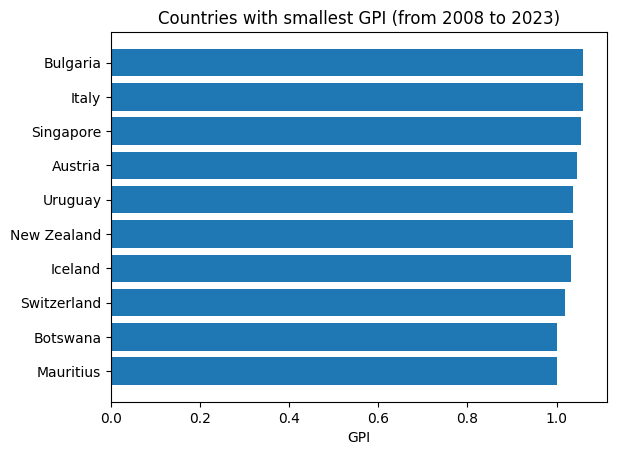

In [40]:
plt.barh(Mean_GPI_Country.nsmallest(10).index, Mean_GPI_Country.nsmallest(10).values)
plt.title("Countries with smallest GPI (from 2008 to 2023)")
plt.xlabel("GPI")

plt.show()

In [41]:
Mean_GPI_Country.sort_values(ascending = True)

Country
Mauritius      1.000000
Botswana       1.001125
Switzerland    1.020000
Iceland        1.032062
New Zealand    1.036750
                 ...   
Sudan          3.102750
Pakistan       3.105563
Somalia        3.171375
Syria          3.188875
Afghanistan    3.325438
Name: GPI, Length: 163, dtype: float64

In [42]:
Mean_GPI_Country.nlargest(10).sort_values(ascending = False).index

Index(['Afghanistan', 'Syria', 'Somalia', 'Pakistan', 'Sudan', 'South Sudan',
       'Iraq', 'Democratic Republic of the Congo', 'Yemen',
       'Central African Republic'],
      dtype='object', name='Country')

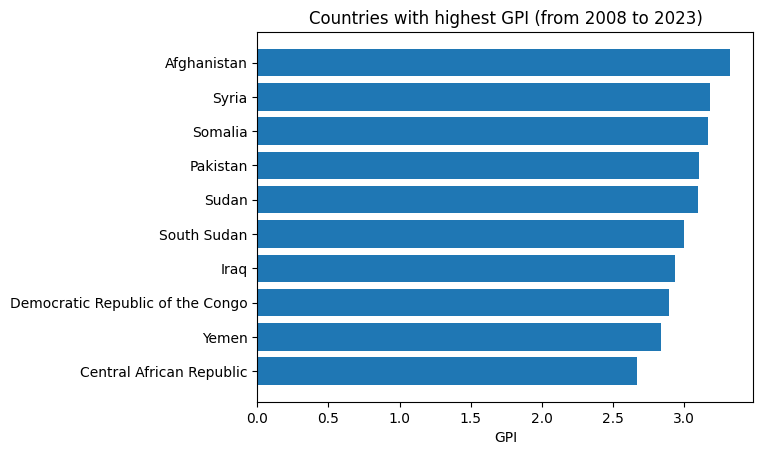

In [43]:
plt.barh(Mean_GPI_Country.nlargest(10).sort_values().index, Mean_GPI_Country.nlargest(10).sort_values().values)
plt.title("Countries with highest GPI (from 2008 to 2023)")
plt.xlabel("GPI")
plt.show()

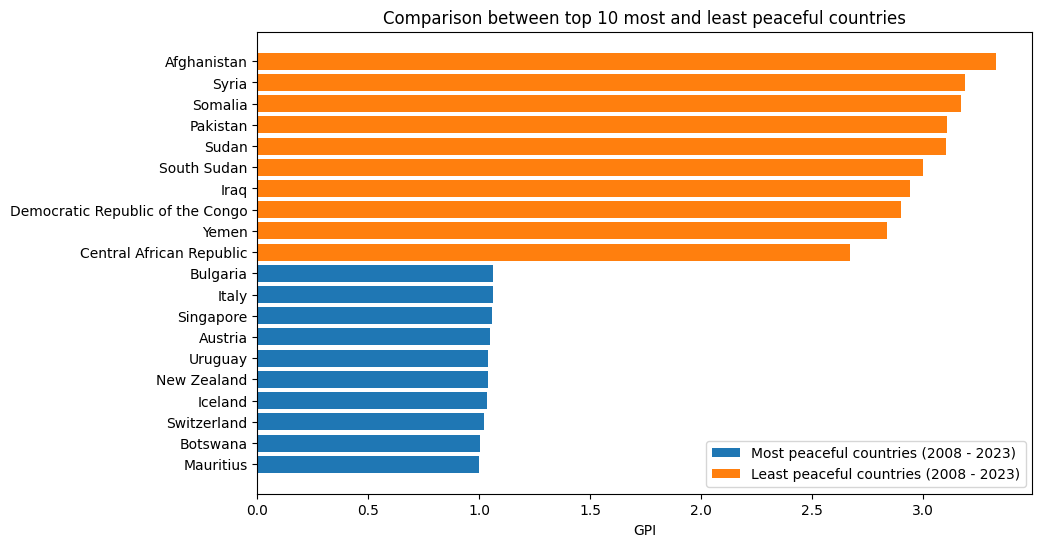

In [44]:
plt.figure(figsize = (10, 6))
plt.barh(Mean_GPI_Country.nsmallest(10).index, Mean_GPI_Country.nsmallest(10).values, label = "Most peaceful countries (2008 - 2023)")
plt.barh(Mean_GPI_Country.nlargest(10).sort_values().index, Mean_GPI_Country.nlargest(10).sort_values().values, label = "Least peaceful countries (2008 - 2023)")
plt.xlabel("GPI")
plt.legend()
plt.title("Comparison between top 10 most and least peaceful countries")
plt.show()


As we saw earlier Afghanistan and Syria are keeping consistently high GPI over the years and they take the first two places for least peaceful country, while the most peaceful countries on average are Mauritius and Botswana. Interestingly, Buglaria takes the 10th place for most peaceful country, which is good.

Using the pivot table that we created before, we can also check which are the countries that improved and deteriored most 2023 compared to 2008.

In [45]:
change_2008_2023 = peace_index_pivot[2023] - peace_index_pivot[2008]

In [46]:
change_2008_2023_pct = (peace_index_pivot[2023] - peace_index_pivot[2008]) / peace_index_pivot[2008]

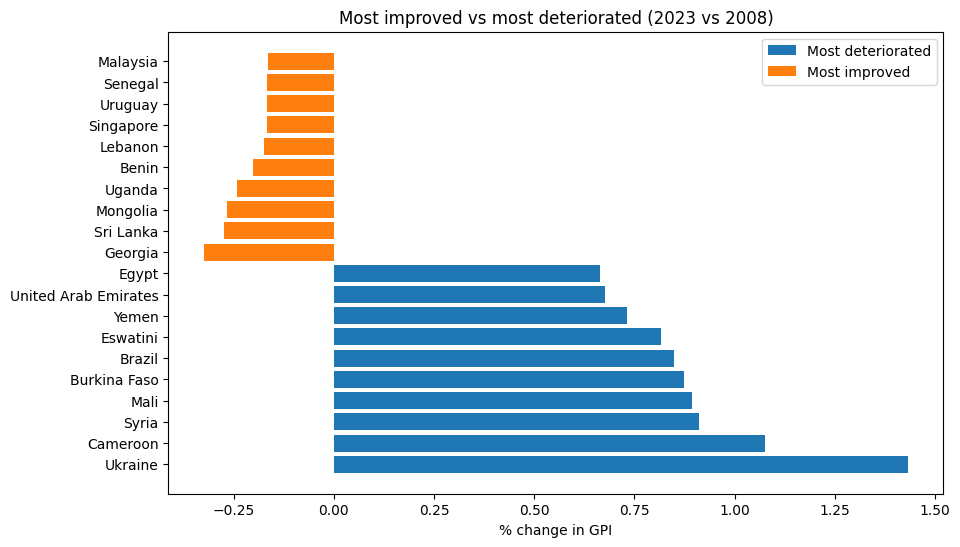

In [47]:
plt.figure(figsize = (10, 6))
plt.barh(change_2008_2023_pct.nlargest(10).index, change_2008_2023_pct.nlargest(10).values, label = "Most deteriorated")
plt.barh(change_2008_2023_pct.nsmallest(10).index, change_2008_2023_pct.nsmallest(10).values, label = "Most improved")
plt.xlabel("% change in GPI")
plt.title("Most improved vs most deteriorated (2023 vs 2008)")
plt.legend()
plt.show()

In [48]:
print("Number of countries with decrease in GPI:", change_2008_2023[change_2008_2023.values < 0].count())
print("Number of countries with increase in GPI:", change_2008_2023[change_2008_2023.values > 0].count())

Number of countries with decrease in GPI: 52
Number of countries with increase in GPI: 101


The most deteriorated country (percent-wise) is Ukraine which was kind of expected. It has increased its GPI index with around 140%. The most improved country is Georgia with decrease of 25-30%. We can also see that almost twice more countries have become less peaceful than those who decreased their GPI.

We will continue our exploration with a review of GPI in 2023.

### GPI 2023

In [49]:
# filtering data for 2023 and creating a new DataFrame
peace_index_2023 = peace_index[peace_index.Year == 2023] 

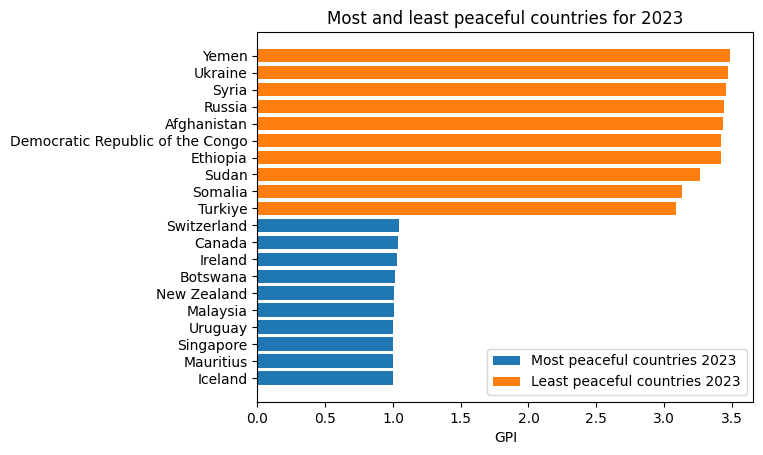

In [50]:
plt.barh(peace_index_2023.nsmallest(10, "GPI").Country, peace_index_2023.nsmallest(10, "GPI").GPI, label = "Most peaceful countries 2023")
plt.barh(peace_index_2023.nlargest(10, "GPI").sort_values(by = "GPI").Country, peace_index_2023.nlargest(10, "GPI").sort_values(by = "GPI").GPI, label = "Least peaceful countries 2023")
plt.xlabel("GPI")
plt.legend()
plt.title("Most and least peaceful countries for 2023")
plt.show()

In [51]:
# getting the change of GPI 2023 vs 2022 so we can see how many countries became more violent vs more peaceful
change_2023 = peace_index_pivot[2023] - peace_index_pivot[2022]

In [52]:
print("The number of countries with decrease in GPI is:", change_2023[change_2023.values < 0].count())
print("The number of countries that became less peaceful is:", change_2023[change_2023.values > 0].count())
print("Top 3 countries which deteriorated most:",list(change_2023.nlargest(3).index))
print("Top 3 countries with highest peace improvement:", list(change_2023.nsmallest(3).index))

The number of countries with decrease in GPI is: 40
The number of countries that became less peaceful is: 79
Top 3 countries which deteriorated most: ['Ukraine', 'Russia', 'Israel']
Top 3 countries with highest peace improvement: ['Libya', 'Burundi', 'India']


A summary of the findings for 2023 GPI:
- 79 countries saw an increase in their GPI. Countries that are least peaceful are Yemen, Ukraine and Syria.
- Ukraine recorded highest deterioration, followed by Russia and Israel.
- 40 countries got more peaceful with Iceland, Maurituis and Singapore leading the way being the most peaceful ones.
- Libya, Burundi and India are the countries which improved their index the most.

#### Choropleth

In order to plot the countries on the world map, we will need their coordinates or "geometry". To get that, we'll use Geopandas to load a file, which can be found online at [Natural Earth Data](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/). The only needed columns are "Admin", which corresponds to country, "ADM0_A3" - country code and "geometry" containing the coordinates data. We will drop the Antarctica from the dataset because it takes too much space on the world map, and we also don't have it in our GPI dataset. After that the peace_index_2023 (we'll plot the data only for 2023) needs to be merged with our newly created geodataframe so that we can use the geometry feature with the GPI data.

In [53]:
# Load the file
world_map = gpd.read_file("data/ne_10m_admin_0_countries.shp")

In [54]:
# select needed columns
world_map = world_map[["ADMIN", "ADM0_A3", "geometry"]]

In [55]:
# rename columns
world_map.columns = ["country", "country_code", "geometry"]

In [56]:
# we can see that the type of world_map is GeoDataFrame
type(world_map)

geopandas.geodataframe.GeoDataFrame

In [57]:
world_map.head()

,country,country_code,geometry
0,Indonesia,IDN,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Malaysia,MYS,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Chile,CHL,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Bolivia,BOL,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Peru,PER,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."


In [58]:
peace_index_2023.head()

,Country,Country_code,Year,GPI
2445,Afghanistan,AFG,2023,3.434
2446,Angola,AGO,2023,1.639
2447,Albania,ALB,2023,1.403
2448,United Arab Emirates,ARE,2023,1.678
2449,Argentina,ARG,2023,1.201


In [59]:
# drop Antarctica
world_map = world_map.drop(world_map.loc[world_map["country"] == "Antarctica"].index)

In [60]:
# merge
peace_index_2023_new = peace_index_2023.merge(world_map, left_on = "Country_code", right_on = "country_code")

In [61]:
# we did not overwrite the dataset but created a new, just in case we need to go back
peace_index_2023_new.head()

,Country,Country_code,Year,GPI,country,country_code,geometry
0,Afghanistan,AFG,2023,3.434,Afghanistan,AFG,"POLYGON ((74.54235 37.02167, 74.54742 37.01567..."
1,Angola,AGO,2023,1.639,Angola,AGO,"MULTIPOLYGON (((13.07370 -4.63532, 13.06533 -4..."
2,Albania,ALB,2023,1.403,Albania,ALB,"POLYGON ((20.56715 41.87318, 20.54172 41.86158..."
3,United Arab Emirates,ARE,2023,1.678,United Arab Emirates,ARE,"MULTIPOLYGON (((56.27906 25.62745, 56.30030 25..."
4,Argentina,ARG,2023,1.201,Argentina,ARG,"MULTIPOLYGON (((-67.19390 -22.82222, -67.14269..."


After the merge, the "peace_index_2023_new" DataFrame needs to be converted to GeoDataFrame, so we can make the choropleth.

In [62]:
peace_index_gdf = gpd.GeoDataFrame(data = peace_index_2023_new, geometry = peace_index_2023_new.geometry, crs = world_map.crs)

In [63]:
type(peace_index_gdf)

geopandas.geodataframe.GeoDataFrame

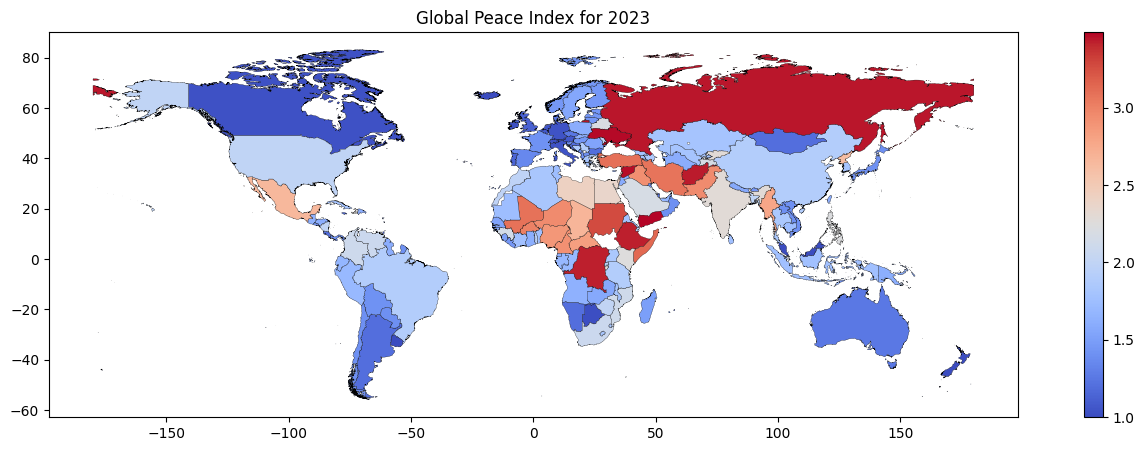

In [64]:
style_kwds = {
    'edgecolor': 'black',   # Set edge color to black
    'linewidth': 0.2       # Set line width to 2
}
ax = peace_index_gdf.plot(column = "GPI", figsize = (17,5), legend = True, cmap = "coolwarm", **style_kwds)
plt.title("Global Peace Index for 2023")
plt.show()

### GPI and GDP per capita

We have a file with GDP per capita per country and per year - from 1960 untill 2020. We'll use it to explore any association between GDP per capita and GPI.

First we need to explore the new dataset and make it clean and tidy enough so we can use it.

In [65]:
# load the gdp file
gdp_data = pd.read_csv("data/gdp_per_capita.csv")

In [66]:
gdp_data.head()

,Country Name,Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,24712.493263,26441.619936,26893.011506,28396.908423,28452.170615,29350.805019,30253.279358,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,147.612227,147.014904,156.189192,182.243917,162.347592,180.214908,190.845484,192.337167,...,1736.166560,1713.899299,1703.596298,1549.037940,1431.778723,1573.063386,1574.978648,1530.059177,1359.618224,NaN
2,Afghanistan,AFG,59.773234,59.860900,58.458009,78.706429,82.095307,101.108325,137.594298,160.898434,...,638.845852,624.315455,614.223342,556.007221,512.012778,516.679862,485.668419,494.179350,516.747871,NaN
3,Africa Western and Central,AFW,107.932233,113.081647,118.831107,123.442888,131.854402,138.526332,144.326212,128.582470,...,1965.118485,2157.481149,2212.853135,1894.310195,1673.835527,1613.473553,1704.139603,1777.918672,1710.073363,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5100.097027,5254.881126,5408.411700,4166.979833,3506.073128,4095.810057,3289.643995,2809.626088,1776.166868,NaN


In [67]:
gdp_data.shape

(266, 64)

In [68]:
gdp_data.dtypes

Country Name     object
Code             object
1960            float64
1961            float64
1962            float64
                 ...   
2017            float64
2018            float64
2019            float64
2020            float64
Unnamed: 65     float64
Length: 64, dtype: object

In [69]:
gdp_data.columns

Index(['Country Name', 'Code', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019',
       '2020', 'Unnamed: 65'],
      dtype='object')

There is a column "Unnamed: 65", which we won't need, so it will be dropped. 

In [70]:
gdp_data = gdp_data.drop(columns = ["Unnamed: 65"])

In [71]:
gdp_data = gdp_data.melt(id_vars = ["Country Name","Code"], var_name = ["Year"], value_name = "GDP")

In [72]:
gdp_data.Year = gdp_data.Year.astype(int)

We'll rename the column "Country Name" to "Country" because it's shorter and then the two datasets are going to be merged. We need to consider that there are two fields we'll be joining - Country and Year. By performing an inner join, we will only get the data that is available in both datasets, so we don't need to worry about filtering the years in one or the other.

In [73]:
gdp_data = gdp_data.rename(columns = {"Country Name": "Country",
                                      "GDP": "GDP_per_capita"})

In [74]:
peace_gdp = peace_index.merge(gdp_data, left_on = ["Country_code", "Year"], right_on = ["Code", "Year"])

In [75]:
peace_gdp = peace_gdp.drop(columns = ["Country_y", "Code"])

In [76]:
peace_gdp = peace_gdp.rename(columns = {"Country_x": "Country"})

In [77]:
peace_gdp.head()

,Country,Country_code,Year,GPI,GDP_per_capita
0,Afghanistan,AFG,2008,3.153,364.663542
1,Angola,AGO,2008,1.655,4080.941034
2,Albania,ALB,2008,1.247,4370.539925
3,United Arab Emirates,ARE,2008,1.000,44498.940507
4,Argentina,ARG,2008,1.403,9020.873323


In [78]:
peace_gdp[peace_gdp.GDP_per_capita.isna()]

,Country,Country_code,Year,GPI,GDP_per_capita
118,North Korea,PRK,2008,2.409,NaN
132,Somalia,SOM,2008,3.196,NaN
279,North Korea,PRK,2009,2.409,NaN
293,Somalia,SOM,2009,3.213,NaN
440,North Korea,PRK,2010,2.409,NaN
454,Somalia,SOM,2010,3.234,NaN
601,North Korea,PRK,2011,2.610,NaN
615,Somalia,SOM,2011,3.239,NaN
687,Eritrea,ERI,2012,1.956,NaN
762,North Korea,PRK,2012,2.610,NaN


Unfortunately there are some countries for which we don't have the GDP per capita in some of the years. It would take us long time to view their GDP per capita in the internet and it's not even sure that we can find anything. For the sake of this review, we will drop the NaN rows.

In [79]:
peace_gdp_clean = peace_gdp.dropna()

In [80]:
peace_gdp_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2051.0,2013.969771,3.736317,2008.000000,2011.000000,2014.000000,2017.00000,2020.000000
GPI,2051.0,1.678601,0.545005,1.000000,1.282000,1.540000,1.95650,3.828000
GDP_per_capita,2051.0,13165.399603,18369.342516,198.352852,1460.162059,4928.126409,15635.04673,102913.450844


We can now see that there are no NaN values.

In [81]:
peace_gdp_clean.corr(numeric_only = True)

,Year,GPI,GDP_per_capita
Year,1.000000,0.078403,0.015432
GPI,0.078403,1.000000,-0.428696
GDP_per_capita,0.015432,-0.428696,1.000000


Using pandas' .corr() we can see that there is a negative correlation between GDP per capita and GPI of -0.42. This is not a very strong correlation, but still, let's investigate more.

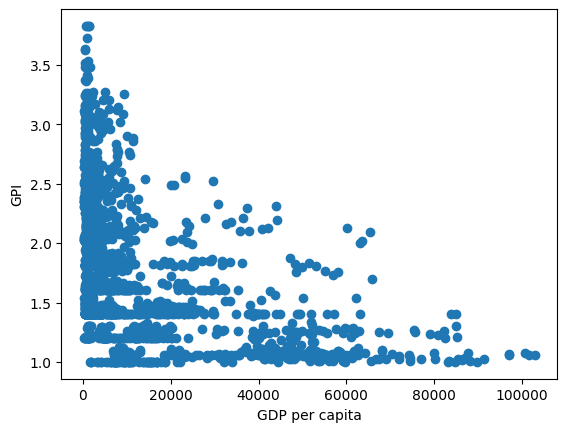

In [82]:
plt.scatter(peace_gdp_clean.GDP_per_capita, peace_gdp_clean.GPI)
plt.xlabel("GDP per capita")
plt.ylabel("GPI")
plt.show()

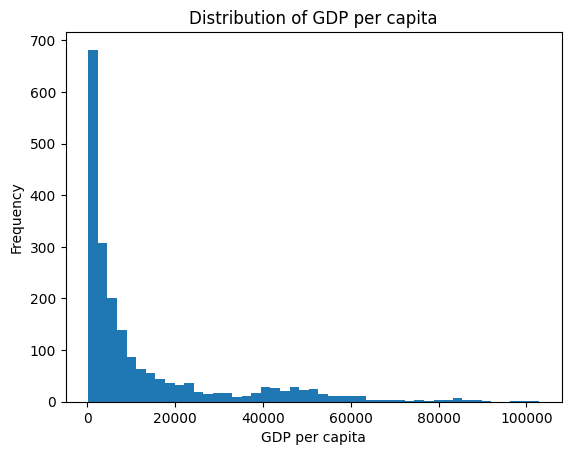

In [83]:
plt.hist(peace_gdp_clean.GDP_per_capita, bins = "fd")
plt.title("Distribution of GDP per capita")
plt.xlabel("GDP per capita")
plt.ylabel("Frequency")
plt.show()

The scatter plot doesn't look very good because the GPI differences are very small. We can still see the negative linear correlation - higher GDP per capita being associated with lower GPI.
As we can also observe on the histogram, the most common GDP per capita is right at the beginning of the chart (low GDP) and there are fewer countries, skewing the chart to the right, with higher GDP per capita. Another thing that we notice on the histogram is that the distribution could be multimodal (due to the two smaller peaks), but we'll not get into that. As the distribution of GDP per capita is highly skewed and it might be good to transform it to have a more Gaussian distribution. By doing that, we should achieve a better correlation, which could lead to more accurate regression results. We'll use PowerTransformer to do that. 

In [84]:
#
pd.options.mode.chained_assignment = None #default = "warn"

In [85]:
pt = PowerTransformer()

In [86]:
# Creating a new feature, which we should then use to fit in the linear regression
peace_gdp_clean[["GDP_scaled"]] = pt.fit_transform(peace_gdp_clean[["GDP_per_capita"]])

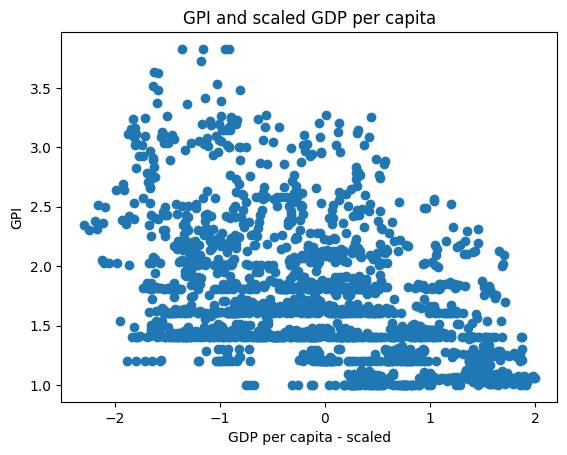

In [87]:
plt.scatter(peace_gdp_clean.GDP_scaled, peace_gdp_clean.GPI)
plt.xlabel("GDP per capita - scaled")
plt.ylabel("GPI")
plt.title("GPI and scaled GDP per capita")
plt.show()

In [88]:
peace_gdp_clean.GDP_scaled.corr(peace_gdp_clean.GPI)

-0.4865251548041834

The correlation has improved a bit, compared to our previous check. Let's continue by fitting our data and running a Linear regrssion.

In [89]:
peace_gdp_clean.dtypes

Country            object
Country_code       object
Year                int32
GPI               float64
GDP_per_capita    float64
GDP_scaled        float64
dtype: object

In [90]:
X = peace_gdp_clean["GDP_scaled"].values.reshape(-1, 1)
y = peace_gdp_clean["GPI"]

In [91]:
model = LinearRegression()

In [92]:
model.fit(X, y)

LinearRegression()

Slope - shows how much of the predicted value of the target variable (GPI) would change for a one-unit change of the independent variable (GDP per capita):

In [93]:
model.coef_

array([-0.26509423])

Intercept - the value of the dependent variable (GPI) when all predictor variables (GDP per capita) equals 0:

In [94]:
model.intercept_

1.6786005200715097

In [95]:
predicted_values = model.predict(X)

In [96]:
r2 = r2_score(y, predicted_values)
print("R-squared =",r2)

R-squared = 0.23670672625723455


This is how the scatter plot would like after adding the regression line:

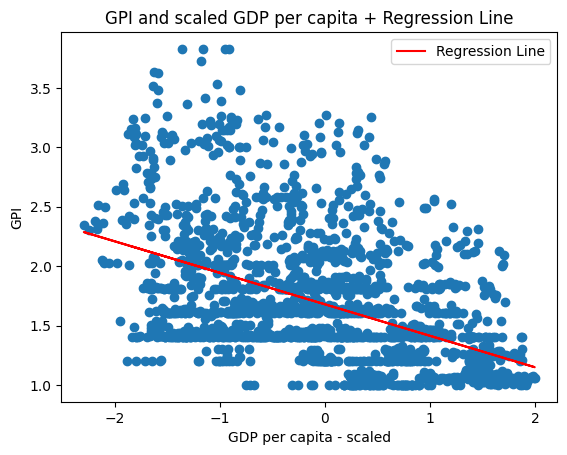

In [97]:
plt.scatter(peace_gdp_clean.GDP_scaled, peace_gdp_clean.GPI)
plt.plot(X, predicted_values, color = "r", label = "Regression Line")
plt.xlabel("GDP per capita - scaled")
plt.ylabel("GPI")
plt.title("GPI and scaled GDP per capita + Regression Line")
plt.legend()
plt.show()

In [98]:
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GPI   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     635.4
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          2.38e-122
Time:                        00:53:09   Log-Likelihood:                -1387.9
No. Observations:                2051   AIC:                             2780.
Df Residuals:                    2049   BIC:                             2791.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6786      0.011    159.616      0.0

The results show us that 24% (r-squared) of the variability observed in the target variable (GPI), can be explained by the regression model. There is a linear relationship between GDP per capita and GPI, but this relationship does not account for a significant portion of the variation in GPI scores. The score is considered weak, but it's significant enough to say that it exists (P>|t| = 0.000).

### GPI and other indicators

Let's continue exploring GPI's relationship with other indicators. For this purpose, a file with world data for 2023 will be used. It shall be loaded and examined. Only the columns that shall be used will be renamed, after which we need to merge the world data file with our familiar GPI dataset. 

In [99]:
world_data = pd.read_csv("data/world-data-2023.csv")

In [100]:
world_data.head()

,Country,code,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land Area(Km2),Armed Forces size,Birth Rate,Calling Code,Capital/Major City,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment rate,Urban_population,Latitude,Longitude
0,Afghanistan,AFG,60,AF,58.10%,"652,230","323,000",32.49,93.0,Kabul,...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Albania,ALB,105,AL,43.10%,"28,748","9,000",11.78,355.0,Tirana,...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
2,Algeria,DZA,18,DZ,17.40%,"2,381,741","317,000",24.28,213.0,Algiers,...,28.10%,1.72,"43,053,054",41.20%,37.20%,66.10%,11.70%,"31,510,100",28.033886,1.659626
3,Andorra,AND,164,AD,40.00%,468,NaN,7.20,376.0,Andorra la Vella,...,36.40%,3.33,"77,142",NaN,NaN,NaN,NaN,"67,873",42.506285,1.521801
4,Angola,AGO,26,AO,47.50%,"1,246,700","117,000",40.73,244.0,Luanda,...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887


In [101]:
world_data = world_data.rename(columns = {"Unemployment rate": "Unemployment_rate",
                                          "Birth Rate": "Birth_rate",
                                          "Life expectancy": "Life_expectancy",
                                          "CPI Change (%)": "CPI_change_pct",
                                          "Land Area(Km2)": "Land_area",
                                         })

Explanation of the indicators that will be used:
- Unemployment Rate: Percentage of the labor force that is unemployed.
- Birth Rate: Number of births per 1,000 population per year.
- Life Expectancy: Average number of years a newborn is expected to live.
- Land Area (Km2): Total land area of the country in square kilometers.
- CPI Change (%): Percentage change in the Consumer Price Index compared to the previous year.

In [102]:
peace_index_2023.head()

,Country,Country_code,Year,GPI
2445,Afghanistan,AFG,2023,3.434
2446,Angola,AGO,2023,1.639
2447,Albania,ALB,2023,1.403
2448,United Arab Emirates,ARE,2023,1.678
2449,Argentina,ARG,2023,1.201


In [103]:
peace_index_2023 = peace_index_2023.merge(world_data, left_on = "Country_code", right_on = "code") # join with world_data

In [104]:
peace_index_2023.head()

,Country_x,Country_code,Year,GPI,Country_y,code,Density\n(P/Km2),Abbreviation,Agricultural Land( %),Land_area,...,Out of pocket health expenditure,Physicians per thousand,Population,Population: Labor force participation (%),Tax revenue (%),Total tax rate,Unemployment_rate,Urban_population,Latitude,Longitude
0,Afghanistan,AFG,2023,3.434,Afghanistan,AFG,60,AF,58.10%,"652,230",...,78.40%,0.28,"38,041,754",48.90%,9.30%,71.40%,11.12%,"9,797,273",33.939110,67.709953
1,Angola,AGO,2023,1.639,Angola,AGO,26,AO,47.50%,"1,246,700",...,33.40%,0.21,"31,825,295",77.50%,9.20%,49.10%,6.89%,"21,061,025",-11.202692,17.873887
2,Albania,ALB,2023,1.403,Albania,ALB,105,AL,43.10%,"28,748",...,56.90%,1.20,"2,854,191",55.70%,18.60%,36.60%,12.33%,"1,747,593",41.153332,20.168331
3,United Arab Emirates,ARE,2023,1.678,United Arab Emirates,ARE,118,AE,5.50%,"83,600",...,17.80%,2.53,"9,770,529",82.10%,0.10%,15.90%,2.35%,"8,479,744",23.424076,53.847818
4,Argentina,ARG,2023,1.201,Argentina,ARG,17,AR,54.30%,"2,780,400",...,17.60%,3.96,"44,938,712",61.30%,10.10%,106.30%,9.79%,"41,339,571",-38.416097,-63.616672


As there are a lot of columns, let's only select the ones that will be needed.

In [105]:
peace_index_2023 = peace_index_2023[["Country_x", "Year", "GPI", "Unemployment_rate", "Life_expectancy", "Population", "CPI_change_pct", "Birth_rate", "Land_area"]]

In [106]:
peace_index_2023 = peace_index_2023.rename(columns = {"Country_x": "Country"})

In [107]:
peace_index_2023.head()

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
0,Afghanistan,2023,3.434,11.12%,64.5,"38,041,754",2.30%,32.49,"652,230"
1,Angola,2023,1.639,6.89%,60.8,"31,825,295",17.10%,40.73,"1,246,700"
2,Albania,2023,1.403,12.33%,78.5,"2,854,191",1.40%,11.78,"28,748"
3,United Arab Emirates,2023,1.678,2.35%,77.8,"9,770,529",-1.90%,10.33,"83,600"
4,Argentina,2023,1.201,9.79%,76.5,"44,938,712",53.50%,17.02,"2,780,400"


In [108]:
peace_index_2023.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,160.0,2023.000000,0.000000,2023.0,2023.000,2023.0000,2023.0000,2023.000
GPI,160.0,1.845094,0.637670,1.0,1.403,1.7035,2.1035,3.486
Life_expectancy,157.0,72.118471,7.739566,52.8,66.200,73.9000,77.6000,84.200
Birth_rate,157.0,20.599682,10.208787,6.4,11.000,18.1800,29.4100,46.080


In [109]:
# check for NAs
peace_index_2023.isna().sum()

Country              0
Year                 0
GPI                  0
Unemployment_rate    3
Life_expectancy      3
Population           1
CPI_change_pct       9
Birth_rate           3
Land_area            1
dtype: int64

We again encounter NaN values with CPI_change_pct having the most. Since this time the dataset is only for 2023, we cannot use mean imputation. Our main goal from these indicators will be to perform hypothesis testing for **Land area** and **Life expectancy**, so let's try to at least fill in the data for the countries related to those indicators.

In [110]:
peace_index_2023[peace_index_2023.Life_expectancy.isna()]

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
92,North Macedonia,2023,1.403,NaN,NaN,"1,836,713",NaN,NaN,"25,713"
120,Palestine,2023,2.659,NaN,NaN,NaN,NaN,NaN,NaN
137,Eswatini,2023,1.816,NaN,NaN,"1,093,238",NaN,NaN,"17,364"


In [111]:
peace_index_2023[peace_index_2023.Land_area.isna()]

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
120,Palestine,2023,2.659,NaN,NaN,NaN,NaN,NaN,NaN


In [112]:
peace_index_2023[peace_index_2023.CPI_change_pct.isna()]

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
32,Cuba,2023,1.805,1.64%,78.7,"11,333,483",NaN,10.17,"110,860"
42,Eritrea,2023,1.787,5.14%,65.9,"6,333,135",NaN,30.30,"117,600"
92,North Macedonia,2023,1.403,NaN,NaN,"1,836,713",NaN,NaN,"25,713"
117,North Korea,2023,2.610,2.74%,72.1,"25,666,161",NaN,13.89,"120,538"
120,Palestine,2023,2.659,NaN,NaN,NaN,NaN,NaN,NaN
131,Somalia,2023,3.131,11.35%,57.1,"15,442,905",NaN,41.75,"637,657"
137,Eswatini,2023,1.816,NaN,NaN,"1,093,238",NaN,NaN,"17,364"
143,Turkmenistan,2023,1.604,3.91%,68.1,"5,942,089",NaN,23.83,"488,100"
153,Uzbekistan,2023,1.805,5.92%,71.6,"33,580,650",NaN,23.30,"447,400"


We neet to get the information for Unemployment rate, life expectancy, CPI change in %, birth rate, and land area for Palestine, North Macedonia and Eswatini and we will also do our best to find information for CPI for the other countries. Unfortunately, it has to be manual and will be checked on the Internet.

In [113]:
peace_index_2023.head()

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
0,Afghanistan,2023,3.434,11.12%,64.5,"38,041,754",2.30%,32.49,"652,230"
1,Angola,2023,1.639,6.89%,60.8,"31,825,295",17.10%,40.73,"1,246,700"
2,Albania,2023,1.403,12.33%,78.5,"2,854,191",1.40%,11.78,"28,748"
3,United Arab Emirates,2023,1.678,2.35%,77.8,"9,770,529",-1.90%,10.33,"83,600"
4,Argentina,2023,1.201,9.79%,76.5,"44,938,712",53.50%,17.02,"2,780,400"


In [114]:
def fill_na_values(country, feature, fill_value):
     index = peace_index_2023.loc[(peace_index_2023["Country"] == f"{country}")].index
     peace_index_2023.loc[index, f"{feature}"] = fill_value

In [115]:
fill_na_values("North Macedonia", "Unemployment_rate", "13.30%")
fill_na_values("North Macedonia", "Life_expectancy", 76.26)
fill_na_values("North Macedonia", "CPI_change_pct", "8.4")
fill_na_values("North Macedonia", "Birth_rate", "10.03")
#fill_na_values("North Macedonia", "Labor_force_pct", "52.03")

fill_na_values("Palestine", "Unemployment_rate", "24.70%")
fill_na_values("Palestine", "Life_expectancy", 74.27)
fill_na_values("Palestine", "Population", "4,923,000")
fill_na_values("Palestine", "CPI_change_pct", "3.6%")
fill_na_values("Palestine", "Birth_rate", "27.70")
#fill_na_values("Palestine", "Labor_force_pct", "45.00")
fill_na_values("Palestine", "Land_area", "6,020")

fill_na_values("Eswatini", "Unemployment_rate", "24.39%")
fill_na_values("Eswatini", "Life_expectancy", 61.05)
fill_na_values("Eswatini", "CPI_change_pct", "4.8%")
fill_na_values("Eswatini", "Birth_rate", "24.18")
#fill_na_values("Eswatini", "Labor_force_pct", "23.78%")

fill_na_values("Cuba", "CPI_change_pct", "3.2%")
fill_na_values("Eritrea", "CPI_change_pct", "7.5%")
fill_na_values("Uzbekistan", "CPI_change_pct", "11.8%")



In [116]:
peace_index_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            160 non-null    object 
 1   Year               160 non-null    int32  
 2   GPI                160 non-null    float64
 3   Unemployment_rate  160 non-null    object 
 4   Life_expectancy    160 non-null    float64
 5   Population         160 non-null    object 
 6   CPI_change_pct     157 non-null    object 
 7   Birth_rate         160 non-null    object 
 8   Land_area          160 non-null    object 
dtypes: float64(2), int32(1), object(6)
memory usage: 10.8+ KB


Good, we did our best and now there are missing values only for CPI for Turkmenistan, Somalia and North Korea - we will drop those records.

In [117]:
peace_index_2023 = peace_index_2023.dropna()

In [118]:
peace_index_2023[peace_index_2023.CPI_change_pct.isna()]

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area


In [119]:
peace_index_2023.head()

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
0,Afghanistan,2023,3.434,11.12%,64.5,"38,041,754",2.30%,32.49,"652,230"
1,Angola,2023,1.639,6.89%,60.8,"31,825,295",17.10%,40.73,"1,246,700"
2,Albania,2023,1.403,12.33%,78.5,"2,854,191",1.40%,11.78,"28,748"
3,United Arab Emirates,2023,1.678,2.35%,77.8,"9,770,529",-1.90%,10.33,"83,600"
4,Argentina,2023,1.201,9.79%,76.5,"44,938,712",53.50%,17.02,"2,780,400"


In [120]:
peace_index_2023.shape

(157, 9)

In [121]:
peace_index_2023.dtypes

Country               object
Year                   int32
GPI                  float64
Unemployment_rate     object
Life_expectancy      float64
Population            object
CPI_change_pct        object
Birth_rate            object
Land_area             object
dtype: object

The next step is to fix the types, the indicators need to be float, not object.

In [122]:
def fix_pct_to_float(dataset, feature):
    dataset[f"{feature}"] = dataset[f"{feature}"].str.replace("%", "").astype(float) / 100
   # return dataset[f"{feature}"]

In [123]:
fix_pct_to_float(peace_index_2023, "Unemployment_rate"), fix_pct_to_float(peace_index_2023, "CPI_change_pct")

(None, None)

In [124]:
peace_index_2023.dtypes

Country               object
Year                   int32
GPI                  float64
Unemployment_rate    float64
Life_expectancy      float64
Population            object
CPI_change_pct       float64
Birth_rate            object
Land_area             object
dtype: object

In [125]:
#fixing the other columns:
peace_index_2023.Birth_rate = peace_index_2023.Birth_rate.astype(float)
peace_index_2023.Population = peace_index_2023.Population.str.replace(",", "").astype(float)
peace_index_2023.Land_area = peace_index_2023.Land_area.str.replace(",", "").astype(float)

In [126]:
peace_index_2023.dtypes

Country               object
Year                   int32
GPI                  float64
Unemployment_rate    float64
Life_expectancy      float64
Population           float64
CPI_change_pct       float64
Birth_rate           float64
Land_area            float64
dtype: object

All columns are now with correct type, we can proceed with checking the correlation between the fields:

In [127]:
peace_index_2023.corr(numeric_only = True)

,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GPI,NaN,1.000000,0.130310,-0.470027,0.138267,0.210449,0.464039,0.186344
Unemployment_rate,NaN,0.130310,1.000000,-0.072735,-0.049242,0.108843,-0.004225,0.031553
Life_expectancy,NaN,-0.470027,-0.072735,1.000000,0.015529,-0.154235,-0.874520,0.069168
Population,NaN,0.138267,-0.049242,0.015529,1.000000,-0.003176,-0.068380,0.435487
CPI_change_pct,NaN,0.210449,0.108843,-0.154235,-0.003176,1.000000,0.108501,0.022588
Birth_rate,NaN,0.464039,-0.004225,-0.874520,-0.068380,0.108501,1.000000,-0.089327
Land_area,NaN,0.186344,0.031553,0.069168,0.435487,0.022588,-0.089327,1.000000


Life Expectancy has the highest correlation coefficient related to GPI. As we said earlier, the fields for which hypothesis testing will be performed are Life_expectancy and Land_area, but we'll include the other indicators too - for fun. The Life expecantcy has a negative correaltion with GPI of -0.47, so it might be easier to say that there is a linear relationship between the two, but the Land_area's correlation with GPI is only 0.18. Will we find any significance of a relationship there? Let's find out.

We want to explore whether or not there is a linear relationship between Life Expectancy and GPI, and between Land area and GPI. In this case:
- $H_0:$ `Life expectancy` does not have a linear connection with `GPI`. `Land area` does not have linear relationship with `GPI`.
- $H_1:$ `Life_expectancy` and `GPI` have a significant linear relationship. There is a linear relationship between `Land_area` and `GPI`.

The threshold value of *p* on can we should agree on is 2%. Therefore if $p\le2\%$, we can reject $H_0$


In [128]:
peace_index_2023.head()

,Country,Year,GPI,Unemployment_rate,Life_expectancy,Population,CPI_change_pct,Birth_rate,Land_area
0,Afghanistan,2023,3.434,0.1112,64.5,38041754.0,0.023,32.49,652230.0
1,Angola,2023,1.639,0.0689,60.8,31825295.0,0.171,40.73,1246700.0
2,Albania,2023,1.403,0.1233,78.5,2854191.0,0.014,11.78,28748.0
3,United Arab Emirates,2023,1.678,0.0235,77.8,9770529.0,-0.019,10.33,83600.0
4,Argentina,2023,1.201,0.0979,76.5,44938712.0,0.535,17.02,2780400.0


Let's run a linear regression with all the variables and see what happens. Before we do though, we must note that our independent variables are of different range - we have Population and Land area which are quite big numbers, and we have percentages (from 0 to 1 numbers), which is quite a difference. To be able to compare the coefficients better and on the same scale, we shall perform a normalization of the independent variables, using MinMaxScaler.

In [129]:
X = peace_index_2023[["Unemployment_rate", "Life_expectancy", "Population", "CPI_change_pct", "Birth_rate", "Land_area"]]

In [130]:
y = peace_index_2023["GPI"]

In [131]:
scaler = MinMaxScaler()

In [132]:
model = LinearRegression()

In [133]:
X_scaled = scaler.fit_transform(X)

In [134]:
model.fit(X_scaled, y)

LinearRegression()

In [135]:
model.intercept_

1.6680109496911029

In [136]:
model.coef_

array([ 0.33610226, -0.47036928,  0.48932403,  0.83793738,  0.7764081 ,
        0.93327541])

In [137]:
coefficients = model.coef_

In [138]:
# Print coefficient for each variable
for i, feature in enumerate(["Unemployment_rate", "Life_expectancy", "Population", "CPI_change_pct", "Birth_rate", "Land_area"]):
    print(f"{feature}: {coefficients[i]}")

Unemployment_rate: 0.3361022631942979
Life_expectancy: -0.4703692808163541
Population: 0.4893240326936973
CPI_change_pct: 0.8379373803742802
Birth_rate: 0.776408103108871
Land_area: 0.9332754063864768


In [139]:
# Calculate the R-squared score
r_squared = model.score(X_scaled, y)

print(f"R-squared: {r_squared}")

R-squared: 0.31849979086770297


At first glance of the coefficient it looks like `Land area` has the strongest impact on GPI. Let's use statsmodels' Ordinary Least Square for its summary:

In [140]:
# OLS method - for the summary:
model = sm.OLS(y, sm.add_constant(X_scaled)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    GPI   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     11.68
Date:                Wed, 11 Oct 2023   Prob (F-statistic):           1.02e-10
Time:                        00:53:09   Log-Likelihood:                -120.16
No. Observations:                 157   AIC:                             254.3
Df Residuals:                     150   BIC:                             275.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6680      0.360      4.631      0.0

Looking at `P>|t|` field in the summary, which is the $p$-value for each of the indicators, we see that `Land_area` ($x6$) has a $p$-value of 0.017, which means that we can deny the $H_0$. However, for `Life_expectancy` the $p$-value is around 14%, which would mean that we cannot reject the $H_0$ due to the alhpa level we set before the start.

So, let's examine the summary and comment the other indicators. If we look at the $p$-values - `Birth_rate` and `Land_area` pass the 5% threshold that is usually set in science.
- `Unemployment_rate` ($x1$), `Life_expectancy` ($x2$), and `Population` ($x3$) do not have significant linear relationship with GPI.
- `CPI_change_pct` ($x4$) - as it turns out the p-value here is a little above 5% which means that it's a little short of being significant at the 5% confidence level.
- `Birth_rate` ($x5$) - positive linear coefficient  - increase in birth rate can be associated with increase in GPI.
- `Land_area` ($x6$) - we can reject the $H_0$ as the p-value is a little below 2%. The variable has a positive linear connection with GPI - and increase in land area could be related to an increase in GPI (deterioration in country's peace). This could mean that bigger countries are more violent and want to impose their will and interest. It could also mean that expansion of state borders could impact negatively the peace. 

_Some calculations needed for the Conclusion_:

In [141]:
peace_index[peace_index.Year == 2023].GPI.mean()  - peace_index[peace_index.Year == 2008].GPI.mean()  # GPI change from 2008 till 2023

0.21168225971370136

In [142]:
(peace_index[peace_index.Year == 2023].GPI.mean()  - peace_index[peace_index.Year == 2008].GPI.mean()) / peace_index[peace_index.Year == 2008].GPI.mean()  #  %-change in GPI

0.12977371509524585

### Conclusion

We explored the GPI over the years and it turned out that since 2008, the world has been deteriorating and becoming a less peaceful place. To be precise, since 2008 the the world's peace index has increased with 0.21 and therefore we can say that the world now is 13% less peaceful than it was in 2008. Associations between GPI and other indicators were investigated - turned out there is a significant lienar relationships with GDP per capita. Land area passed the hypothesis testing and we denied the null hypothesis making the linear connection between Land area and GPI statistically significant too.

### Sources

- [GPI - Vision of humanity](https://www.visionofhumanity.org/maps/#/)
- [GPI - Wikipedia](https://en.wikipedia.org/wiki/Global_Peace_Index)
- [GPI - EconomicsAndPeace](https://www.economicsandpeace.org/wp-content/uploads/2023/06/GPI-2023-Web.pdf)
- [GPI and Life Expectancy - NLM](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4402412/)
- [Kaggle](https://www.kaggle.com/)
